# Long Short Term Memory (LSTM) Model

LSTMs are variations of recurrent neural networks.

*Acknowledgments:* Presented with [help](https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning) and [more help](https://github.com/kshitij-raj/Stock-Price-Prediction-LSTM).

In [2]:
## Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import  EarlyStopping
from keras import optimizers

In [3]:
## Load, preprocess data
df = pd.read_csv('./TSLA.csv')

# We will train on closing prices
df = df.reset_index()['Close']
sc = MinMaxScaler()
df = sc.fit_transform(np.array(df).reshape(-1,1))
train, test = train_test_split(df, test_size = 0.2, shuffle = False)

# Modify training, testing data with timesteps
def create_timeseries(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[(i + time_step), 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_timeseries(train, time_step)
X_test, y_test = create_timeseries(test, time_step)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [4]:
## Build and fit LSTM
model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (time_step, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

In [5]:
optimizer = optimizers.Adam(learning_rate = 0.01)

model.compile(loss = 'mean_squared_error', optimizer = optimizer)

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto', verbose = 1)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100,
                    batch_size = 64, verbose = 1, callbacks = [early_stop])

Epoch 1/100
35/35 [==============================] - 3s 77ms/step - loss: 0.0017 - val_loss: 0.2255
Epoch 2/100
35/35 [==============================] - 2s 62ms/step - loss: 2.9093e-04 - val_loss: 0.0785
Epoch 3/100
35/35 [==============================] - 2s 51ms/step - loss: 3.8997e-05 - val_loss: 0.0591
Epoch 4/100
35/35 [==============================] - 2s 52ms/step - loss: 1.2194e-05 - val_loss: 0.0566
Epoch 5/100
35/35 [==============================] - 2s 50ms/step - loss: 1.0804e-05 - val_loss: 0.0532
Epoch 6/100
35/35 [==============================] - 2s 51ms/step - loss: 1.1621e-05 - val_loss: 0.0537
Epoch 7/100
35/35 [==============================] - 2s 50ms/step - loss: 1.1032e-05 - val_loss: 0.0526
Epoch 8/100
35/35 [==============================] - 2s 50ms/step - loss: 1.0476e-05 - val_loss: 0.0520
Epoch 9/100
35/35 [==============================] - 2s 60ms/step - loss: 1.0234e-05 - val_loss: 0.0471
Epoch 10/100
35/35 [==============================] - 2s 60ms/step -

35/35 [==============================] - 2s 50ms/step - loss: 3.0912e-06 - val_loss: 0.0139
Epoch 80/100
35/35 [==============================] - 2s 49ms/step - loss: 4.2008e-06 - val_loss: 0.0154
Epoch 81/100
35/35 [==============================] - 2s 49ms/step - loss: 3.3180e-06 - val_loss: 0.0177
Epoch 82/100
35/35 [==============================] - 2s 49ms/step - loss: 3.2874e-06 - val_loss: 0.0140
Epoch 83/100
35/35 [==============================] - 2s 57ms/step - loss: 2.7644e-06 - val_loss: 0.0155
Epoch 84/100
35/35 [==============================] - 2s 61ms/step - loss: 3.4799e-06 - val_loss: 0.0121
Epoch 85/100
35/35 [==============================] - 2s 56ms/step - loss: 2.8373e-06 - val_loss: 0.0128
Epoch 86/100
35/35 [==============================] - 2s 50ms/step - loss: 3.5168e-06 - val_loss: 0.0112
Epoch 87/100
35/35 [==============================] - 2s 49ms/step - loss: 2.7303e-06 - val_loss: 0.0119
Epoch 88/100
35/35 [==============================] - 2s 50ms/step -

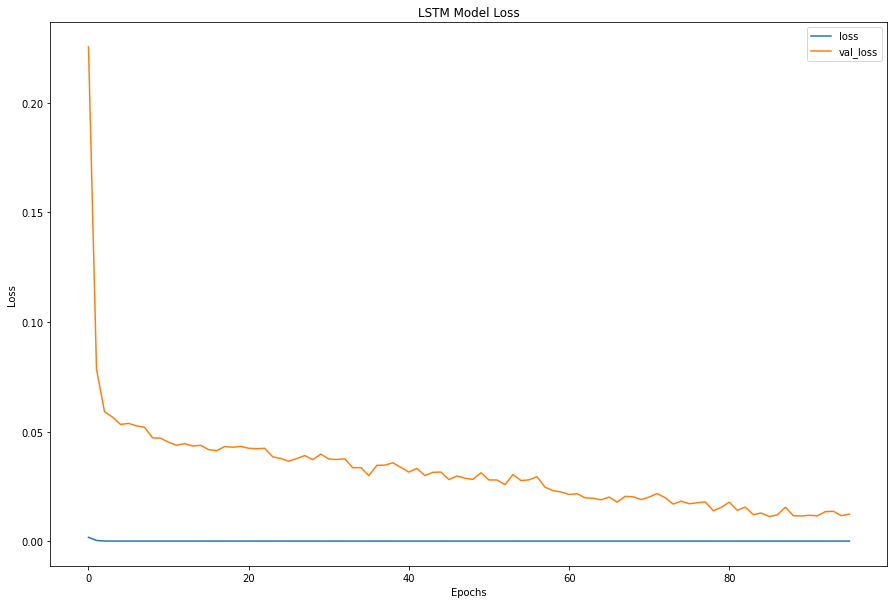

In [9]:
## Analyze Model Loss
plt.figure(figsize = (15, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel("Epochs")
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

Here, ``loss`` is the MSE for our training data, and ``val_loss`` is the MSE for our cross-validation data.

In [7]:
##Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Invert transformation to get stock prices
train_pred = sc.inverse_transform(train_pred)
test_pred = sc.inverse_transform(test_pred)

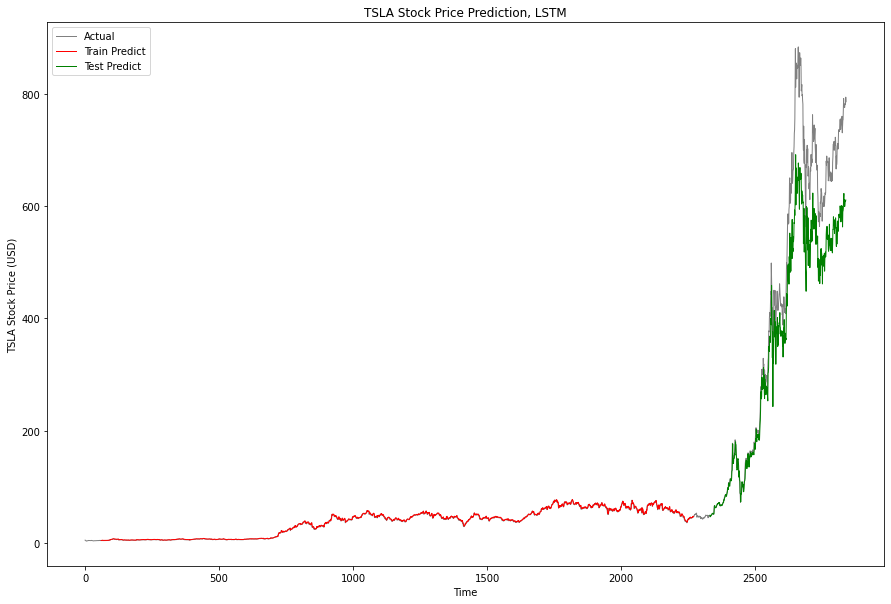

In [8]:
## Observed v. Predicted Results
# Shift train prediction for plotting
train_pred_plot = np.empty_like(df)
train_pred_plot[:, :] = np.nan
train_pred_plot[time_step: len(train_pred) + time_step, :] = train_pred

# Shift test prediction for plotting
test_pred_plot = np.empty_like(df)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(train_pred) + (time_step * 2) + 1: len(df) -1, :] = test_pred

plt.figure(figsize = (15, 10))
plt.plot(sc.inverse_transform(df), color = 'gray', linewidth = 1, label = 'Actual')
plt.plot(train_pred_plot, linewidth = 1, color = 'red', label = 'Train Predict')
plt.plot(test_pred_plot, linewidth = 1, color = 'green', label = 'Test Predict')
plt.legend()
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price (USD)')
plt.title('TSLA Stock Price Prediction, LSTM')
plt.show()